# Titanic
Desafio do Kaggle ([link](https://www.kaggle.com/c/titanic/overview))
![](https://storage.googleapis.com/kaggle-competitions/kaggle/3136/logos/header.png)

## Importar dados

In [1]:
import numpy as np
import pandas as pd
import plot_dataset as pdt

#get train set
df = pd.read_csv('./data/train.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
import plotly.figure_factory as ff

figure = ff.create_scatterplotmatrix(
    df[['Age', 'Fare', 'Pclass',      
        'SibSp','Parch', 'Survived']],
    diag='histogram',
    index='Survived')

A amostra dos dados acima mostra vários campos de cada passageiro do RMS Titanic:
- **Survived**: Sobreviveu? (0 = Não; 1 = Sim)
- **Pclass**: Classe da cabine (1 = Superior; 2 = Médio; 3 = Baixa)
- **Name**: Nome do passageiro
- **Sex**: Gênero do passageiro
- **Age**: Idade do passageiro (alguns contém `NaN`)
- **SibSp**: Quantidade de irmãos e cônjuges a bordo com o passageiro
- **Parch**: Quantidade de pais e crianças a bordo com o passageiro
- **Ticket**: Número do Ticket do passageiro
- **Fare**: Preço da passagem cobrado ao passageiro
- **Cabin** Número da cabine do passageiro (alguns contém `NaN`)
- **Embarked**: Porto de embarque do passageiro (C = Cherbourg; Q = Queenstown; S = Southampton)

Portanto, `Survived` é o rótulo (_label_) enquanto os outros campos são os atributos (_features_) para a aplicação de Aprendizado de Máquina Supervisionado (_Supervised Machine Learning_).

## Explorar dados
Vamos explorar visualizando como os dados estão distribuídos, seus valores limites e suas relações entre si em busca de _insights_.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000075B6EF7E10>,
      dtype=object)

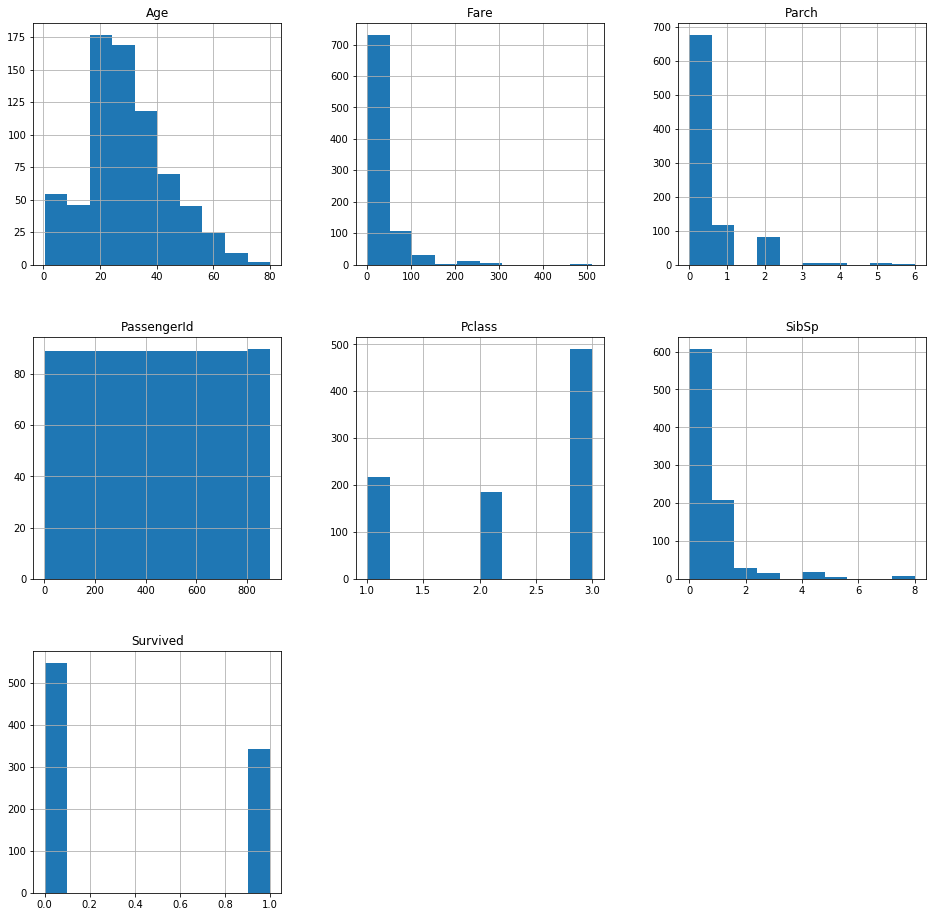

In [3]:
df.hist(figsize=(16, 16))

O histograma acima mostra que a **proporção de sobreviventes e óbitos é cerca de 60%**. Essa métrica é muito importante, pois toda vez que essa propoção mudar em algum atributo significa que esse é relevante.

Porém, alguns atributos foram omitidos porque contém strings ao invés de números.

Portanto, vamos plotar outro histograma personalizado que inclui também os atributos com strings. Além disso, vamos separar os diferentes valores do rótulo (0 e 1) para tentar identificar mudanças na proporção de 60%.

C:\Users\Diogo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



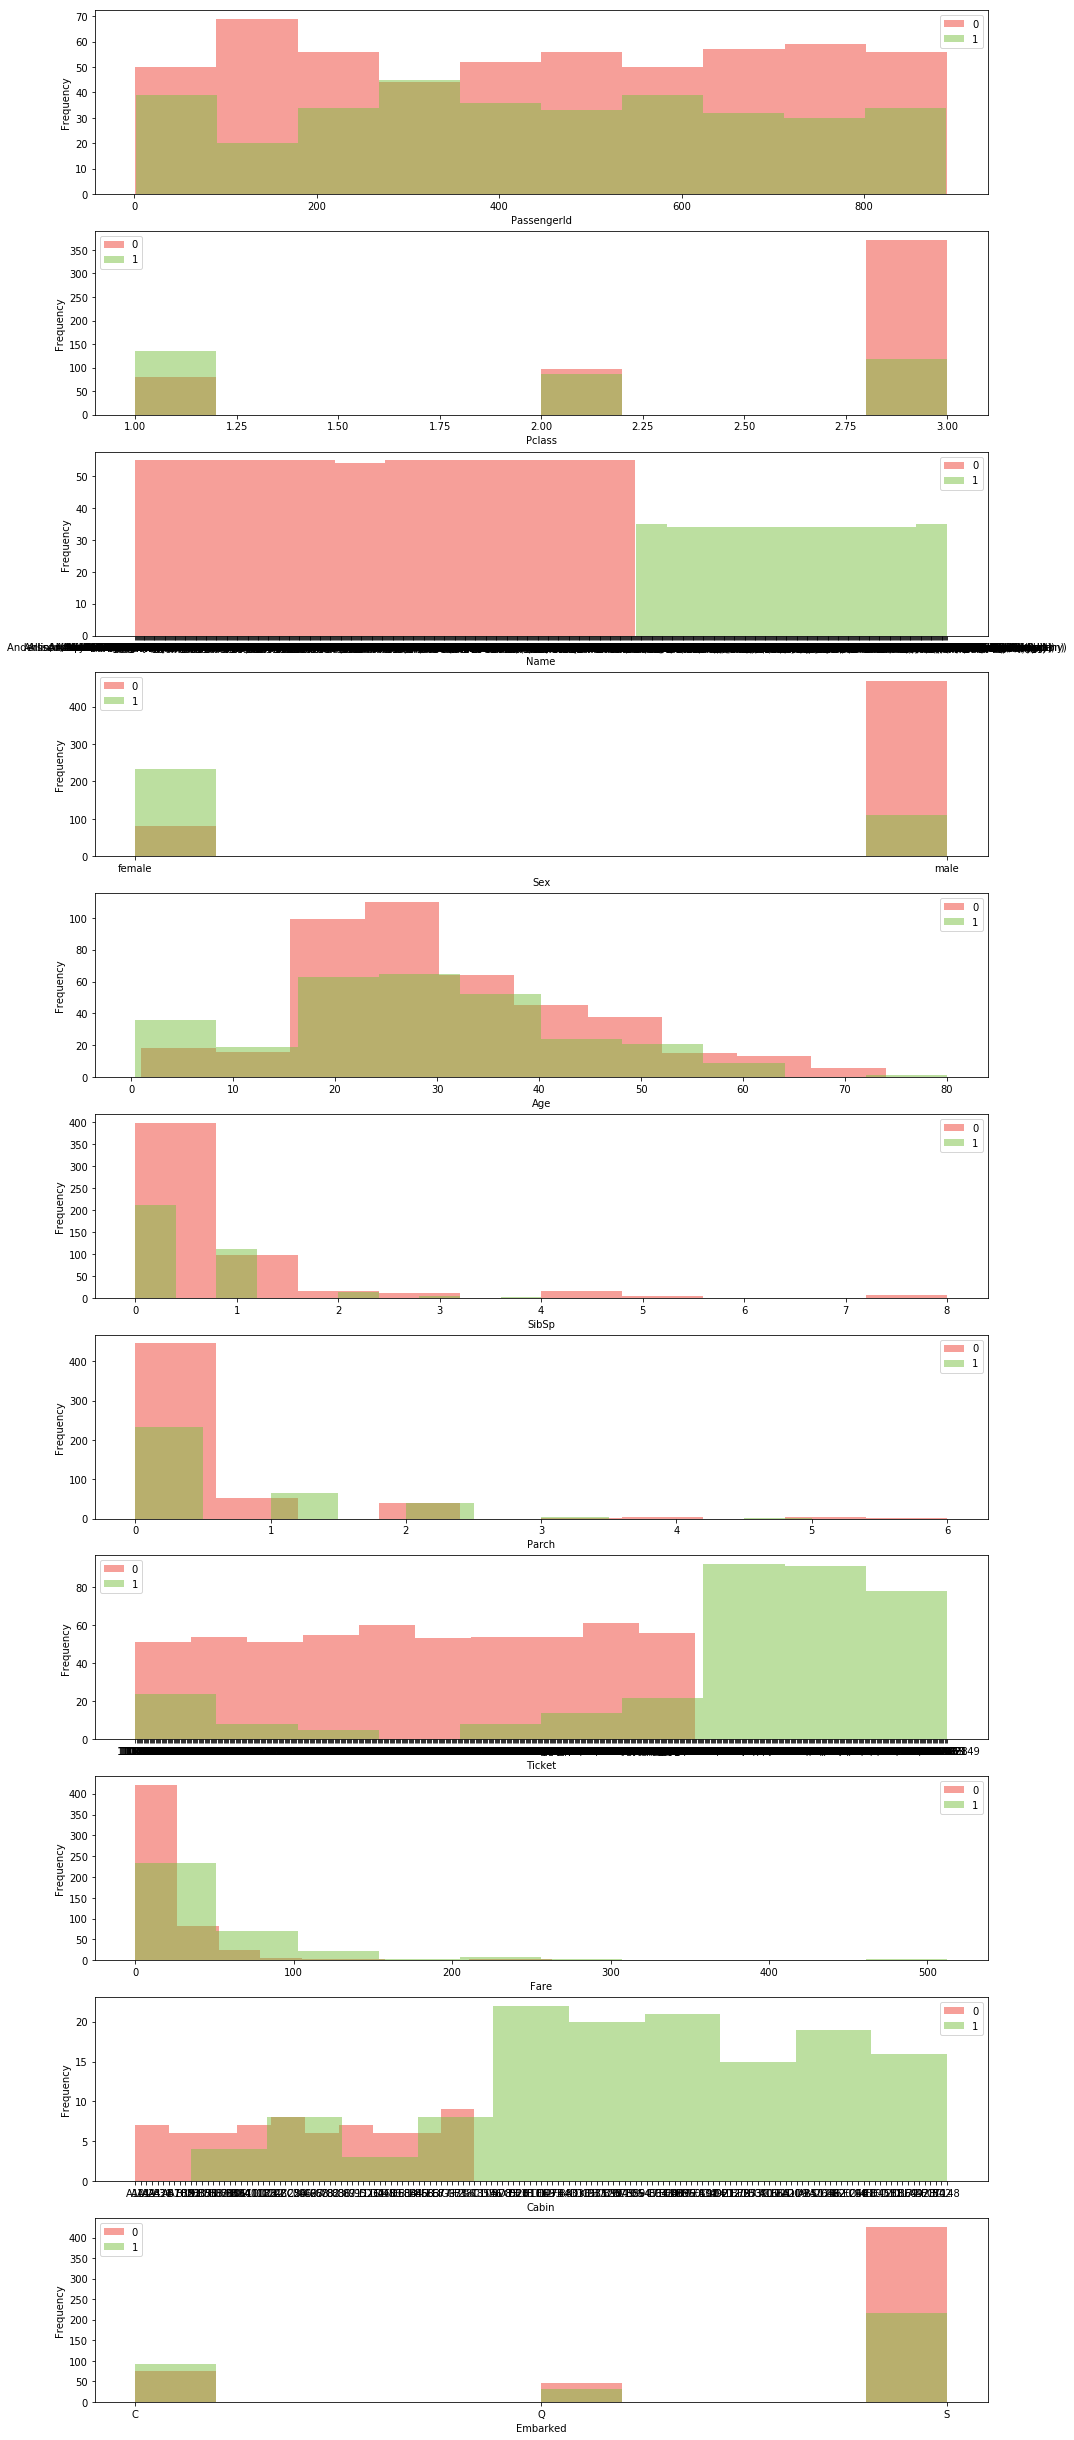

In [4]:
pdt.hist_labels(df, 'Survived')

No histograma separado por atributos acima, alguns parecem muito úteis para identificar diferença na proporção de 60% entre sobreviventes e óbitos:
- `Pclass`
- `Sex`
- `Age` (abaixo de 18 anos)
- `SibSp` (acima de 0)
- `Parch` (acima de 0)
- `Ticket` (número altos)
- `Fare` (acima de 30)
- `Cabin` (metade com números mais altos)
- `Embarked` (Cherbourg)

Portanto, os dados mostram que há mais chances de sobreviver quem:
- for mulher;
- for criança;
- ter acompanhante na viagem; ou
- ter pago por uma passagem mais cara (o que provavelmente tem relação com a cabine e porto de embarque).

Os atributos restantes não mudaram a proporção de 60%: `PassengerId`, `Name`, `Cabin`, `Ticket`.

Tais atributos precisam possuem variedade de valores muito alta, e por isso não contribuem para a entropia dos dados. 

In [5]:
feature = 'Sex'
print(df[feature].count())
print(df[feature].drop_duplicates().count())

891
2


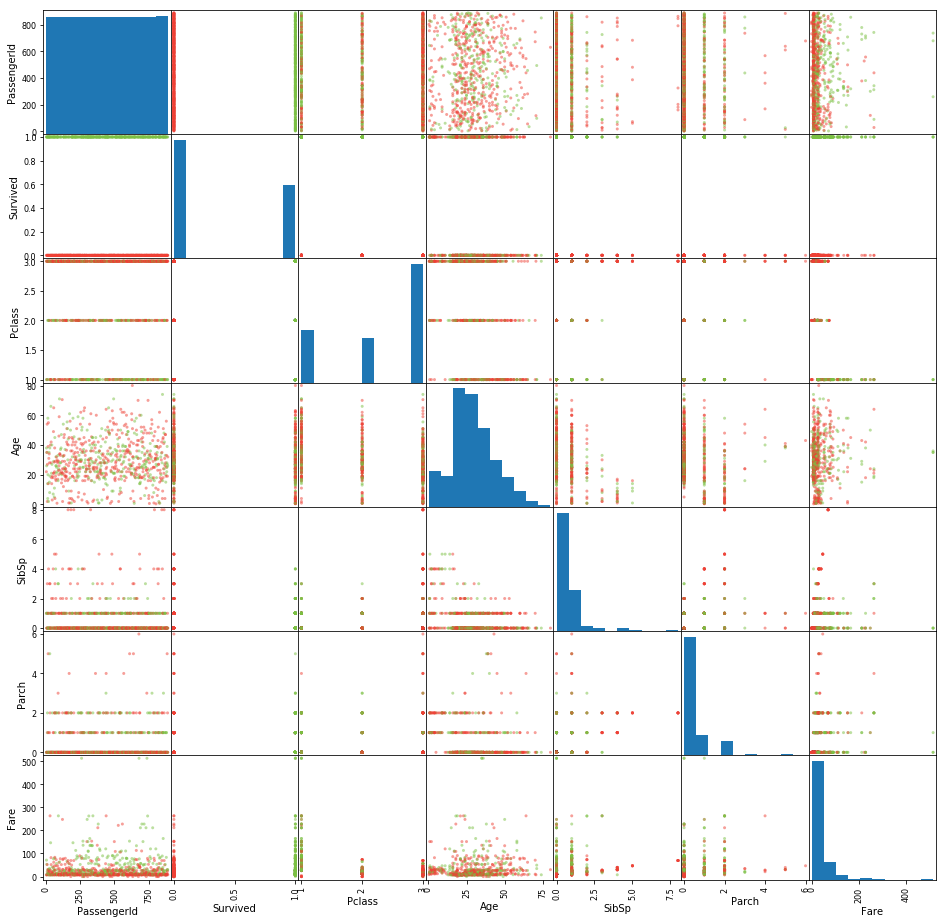

In [6]:
pdt.scatter_labels(df, 'Survived')

A matrix de espalhamento acima mostra que há relação entre alguns atributos. Alguns atributos são particularmente úteis para separar sobreviventes (verdes) de óbitos (vermelhos), por exemplo `SibSp`-`Parch`-`Fare`.

Porém, a separação entre verdes e vermelhos não é muito evidente. Além disso, alguns atributos parecem não ter qualquer relação com a sobrevivência.

## Prepara Dados

Remover atributos que não contribuem para o modelo.

In [7]:
dataset = df.copy()
ignore_features = ['PassengerId','Name','Ticket','Cabin']
dataset = dataset.drop(columns=ignore_features)
dataset.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,NaN,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


Os campos com `NaN` serão sobrescritos com valores que não alteram a propoção de 60%. Dessa forma, não alteramos a probabilidade de sobrevivência nos campos vazios e não descartamos os outros atributos que possuem valores que podem contribuir para o modelo.

In [8]:
dataset.loc[df['Age'].isna(), 'Age'] = 20.0
dataset.loc[df['Embarked'].isna(), 'Embarked'] = 'S'
dataset.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,20.0,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


In [9]:
dataset.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [10]:
change_to_categorical = ['Sex', 'Embarked']

for feature in change_to_categorical:
    dataset[feature] = dataset[feature].astype('category')
    
dataset.dtypes

Survived       int64
Pclass         int64
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked    category
dtype: object

In [11]:
dataset = pd.get_dummies(dataset, columns=change_to_categorical)

dataset.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


## Modelos Preditivos


O rótulo `Survived` possui apenas 2 valores: 0 (óbito) ou 1 (sobrevivente). Portanto, o modelo preditivo deve ser do tipo Classificador.

A maneira como os dados estão distribuídos favorecem modelos que classificam questionando diretamente os atributos, tais como Árvore de Decisão (_Decision Tree_) ou os do tipo Agregação (_Ensemble_) tais como _Bagging_, _AdaBoost_, _Random Forest_ e _Gradient Boosting_.

Há poucos dados e, por isso, não há aparente justificativa para empregar modelos mais complexos tais como não-lineares ou redes neurais. Além disso, a dependência entre atributos desfavorece o Naive Bayes.

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

target = 'Survived'

X = dataset.drop(columns={target}).values
y = dataset[target].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

classifiers = [
    KNeighborsClassifier(2),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# iterate over classifiers
for clf in classifiers:
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('score = ' + str(score) + ' : ' + clf.__class__.__name__)

score = 0.6946778711484594 : KNeighborsClassifier
score = 0.7226890756302521 : GaussianProcessClassifier
score = 0.7675070028011205 : DecisionTreeClassifier
score = 0.7983193277310925 : RandomForestClassifier
score = 0.7815126050420168 : MLPClassifier
score = 0.7983193277310925 : AdaBoostClassifier
score = 0.8067226890756303 : BaggingClassifier
score = 0.7759103641456583 : DecisionTreeClassifier
score = 0.7843137254901961 : GaussianNB
score = 0.7619047619047619 : QuadraticDiscriminantAnalysis


C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning:

Variables are collinear



Todos os modelos tiveram acurácia acima de 60% e, portanto, tem desempenho acima de um estimador básico.

**AdaBoostClassifier** teve melhor acurácia e por isso foi selecionado como candidato final.

Agora vamos otimizar seus hyper-parâmetros.

In [34]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [10, 20, 50, 100, 200],
         'learning_rate' : [0.01,0.05,0.1,0.3,1],
         }

params = {'max_depth': [2, 30, 50, 100, 200],
         'learning_rate' : [0.01,0.05,0.1,0.3,1],
         }

clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params, cv=5)
#clf = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=params, cv=5)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.score(X_test, y_test))

{'learning_rate': 0.3, 'n_estimators': 100}
0.7871148459383753


In [35]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)
print('Cross-validated scores range: (' + str(round(scores.mean(),2)) + ' +- ' + str(round(scores.std()*2,2)) + ' )%')

Cross-validated scores range: (0.8 +- 0.03 )%


A acurácia do modelo está dentro da faixa de acurácia do _Cross Validation_ com 65% de probabilidade (2 sigma).

Portanto, não há indícios de _overfitting_. Esse resultado já era esperado porque o AdaBoost costuma ser robusto a _overfitting_.

## Predizer amostra de Teste

In [15]:
#get test set
df_test = pd.read_csv('./data/test.csv')

df_test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [16]:
dataset_test= df_test.copy()
dataset_test = dataset_test.drop(columns=ignore_features)
dataset_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [17]:
dataset_test.loc[df_test['Age'].isna(), 'Age'] = 20.0
dataset_test.loc[df_test['Fare'].isna(), 'Fare'] = 8.0
dataset_test.loc[df_test['Embarked'].isna(), 'Embarked'] = 'S'
dataset_test.isna().sum()

for feature in change_to_categorical:
    dataset_test[feature] = dataset_test[feature].astype('category')
    
dataset_test = pd.get_dummies(dataset_test, columns=change_to_categorical)

y_pred = clf.predict(dataset_test)

In [18]:
df_submit = pd.DataFrame({'PassengerId':df_test['PassengerId'], 'Survived':y_pred})

df_submit.to_csv('df_submit.csv', index=False)

df_submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [19]:
df_submit['Survived'].sum() / df_submit.shape[0]

0.3444976076555024

A proporção de sobreviventes na amostra de teste está na mesma ordem de grandeza da amostra de treino. Essa verificação é apenas um _Sanity Check_.

Tudo parece estar em ordem!

## Submissão

O arquivo `df_submission.csv` foi submetido ao Kaggle e o teste com 50% da amostra resultou em acurácia de 77%, sendo maior do que a estimativa de referência de 60%. Essa acurácia está dentro da faixa esperada (0,80 +- 0,03)% e, portanto, não houve overfitting.

Como conclusão, o presente modelo preditivo é considerado útil para predizer sobreviventes do Titanic.